![](img/banner.png)
%%HTML
<script src="require.js"></script>


# Lecture 8. Hidden Markov Models

**Mahmood Amintoosi, Spring 2024**

Computer Science Dept, Ferdowsi University of Mashhad

In [1]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/machine-learning'):
    !git clone -q https://github.com/fum-cs/machine-learning.git /content/machine-learning
    !pip --quiet install -r /content/machine-learning/requirements_colab.txt
    %cd machine-learning/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = False # Set to True for interactive plots
if interactive:
    fig_scale = 0.61
    print_config['font.size'] = 7
    print_config['xtick.labelsize'] = 5
    print_config['ytick.labelsize'] = 5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.28
    plt.rcParams.update(print_config)


## Hidden Markov Models (HMMs)

Hidden Markov Models are widely used in various fields, including natural language processing, speech recognition, and bioinformatics. They are probabilistic models that capture sequences of observations (or symbols) generated by an underlying hidden state process. Here are the key components of an HMM:

1. **States**: An HMM consists of a set of hidden states. Each state represents a different situation or condition. For example, in part-of-speech tagging, states could correspond to different parts of speech (e.g., noun, verb, adjective).

2. **Observations (Emissions)**: At each time step, the HMM emits an observation (symbol) based on the current hidden state. These observations can be words, phonemes, or any other relevant symbols.

3. **Transition Probabilities**: HMMs model how the hidden states transition from one to another. Transition probabilities represent the likelihood of moving from one state to another.

4. **Emission Probabilities**: Each hidden state has associated emission probabilities for generating specific observations. These probabilities indicate how likely an observation is given the current state.

## Viterbi Algorithm

The Viterbi algorithm is an efficient **dynamic programming** technique used to find *the most likely sequence of hidden states* (the Viterbi path) given a sequence of observations. It's particularly useful for decoding in HMMs. Here's how it works:

1. **Initialization**: Initialize a matrix where each cell represents the probability of being in a specific state at a given time step. Set the initial probabilities based on the starting state probabilities and emission probabilities.

2. **Recursion**: Iterate through the observation sequence. At each time step, update the probabilities for each state by considering the previous time step's probabilities and transition probabilities.

3. **Backtracking**: After processing all observations, backtrack through the matrix to find the most likely sequence of states (the Viterbi path).

The Viterbi algorithm has linear runtime with respect to the length of the observation sequence, making it efficient for practical use.

# Dynamic Programming and Seam Carving

Dynamic programming is a powerful technique for solving problems by breaking them down into smaller, overlapping subproblems. It's widely used in various fields, including computer science, optimization, and image processing. One intriguing application of dynamic programming is **seam carving**. Seam carving is used in content-aware image resizing, in which, its algorithm is very similar to Viterbi algorithm.

## Content-Aware Image Resizing
Content-aware image resizing aims to change the width or height of an image while preserving its essential features. Traditional methods like cropping and scaling have limitations, often resulting in loss of important content or visible artifacts. Seam carving offers an elegant solution by identifying and removing low-energy seams from the image.

### What Are Seams?
In the context of seam carving, a **seam** is a connected path of pixels that spans the entire height or width of the image. The goal is to find the lowest-energy seam (i.e., the least interesting part of the image) and remove it. Seam carving ensures that the removed seam doesn't disrupt the overall visual coherence.

### Seam Carving Process
1. **Energy Calculation**: First, we compute the energy of each pixel in the image. Energy represents the importance of a pixel based on its color gradients. Higher energy corresponds to more visually significant regions.

2. **Dynamic Programming**: Seam carving uses dynamic programming to find the optimal seam. For vertical resizing (reducing width), we find the seam with the minimum cumulative energy from top to bottom. The seam moves left or right by at most one pixel in each row.

3. **Seam Removal**: Once we identify the lowest-energy seam, we remove it by shifting the remaining pixels to close the gap. This process is repeated until the desired image width is achieved.

### Example
Consider the [following image](https://www.ulfdittmer.com/imagej/seam-carving.html); Seam carving identifies the lowest-energy seam, which typically runs through less interesting areas. By removing this seam, we resize the image without sacrificing essential details.

![Seam-Carving Image](img/seam-carving.jpg)




## Dynamic Programming and Seam Carving: A Viterbi Perspective

Dynamic programming plays a crucial role in both seam carving and the Viterbi algorithm. While seam carving focuses on image resizing, the Viterbi algorithm is widely used for decoding hidden Markov models (HMMs). Let's explore their similarities and differences.

## Seam Carving Algorithm (Viterbi-Like Perspective)

1. **Energy Calculation**:
   - Compute the energy of each pixel in the image (similar to emission probabilities in HMMs).
   - Define an energy matrix where each entry represents the cumulative energy from the top-left corner to that pixel.

2. **Dynamic Programming Table**:
   - Create a dynamic programming table (similar to the Viterbi trellis).
   - Initialize the first row of the table with the energy values from the energy matrix.

3. **Optimal Seam Identification**:
   - For each subsequent row, compute the cumulative energy by considering the neighboring pixels (left, above-left, and above-right).
   - Update the dynamic programming table with the minimum cumulative energy path.
   - The optimal seam corresponds to the path with the lowest cumulative energy in the last row.

4. **Seam Removal**:
   - Remove the pixels along the identified seam.
   - Shift the remaining pixels to close the gap.
   - Repeat until the desired image width is achieved.


- Seam carving and the Viterbi algorithm exemplify the versatility of dynamic programming. Whether we're resizing images or decoding hidden states, dynamic programming provides elegant solutions.
- Seam carving minimizes energy, while the Viterbi algorithm maximizes probabilities.
- Both algorithms find an optimal path based on dynamic programming principles.

### Seam-carving implementation

My first implementation of seam-carving was in MATLAB, then by Python. In the following, my new code which is a combination of my previous code and [Karthik Karanth](https://karthikkaranth.me/blog/implementing-seam-carving-with-python/)'s code is provided.

In [2]:
"""
This is a combination of Karthik Karanth and my implementation for seam carving 
"""


def calc_energy(img):
    Ix, Iy = np.gradient(rgb2gray(img))
    energy_map = np.abs(Ix) + np.abs(Iy)
    return energy_map


def crop_c(img, num_seams):
    r, c, _ = img.shape
    for i in range(min([num_seams, c])):
        img = carve_column(img)
    return img


def crop_r(img, num_seams):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, num_seams)
    img = np.rot90(img, 3, (0, 1))
    return img


def carve_column(img):
    r, c, _ = img.shape
    M, backtrack = minimum_seam(img)
    mask = np.ones((r, c), dtype=bool)

    j = np.argmin(M[-1])
    for i in reversed(range(r)):
        mask[i, j] = False
        j = backtrack[i, j]

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img


def find_optimal_seam(M, backtrack):
    r, c = M.shape
    # Find the column index with the minimum energy in the last row
    j = np.argmin(M[-1])

    # Initialize an empty list to store the seam indices
    seam = []

    # Backtrack from the last row to the first row
    for i in reversed(range(r)):
        seam.append((i, j))
        j = backtrack[i, j]

    # Reverse the seam to get the correct order
    seam.reverse()
    return seam


# usage:
# seam_indices = find_optimal_seam(M, backtrack)
# Now seam_indices contains the optimal path as a list of (i, j) indices


def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int32)

    for i in range(1, r):
        for j in range(0, c):
            left_most_col = max(0, j - 1)
            idx = np.argmin(M[i - 1, left_most_col : j + 2])
            backtrack[i, j] = left_most_col + idx
            min_energy = M[i - 1, left_most_col + idx]

            M[i, j] += min_energy

    return M, backtrack

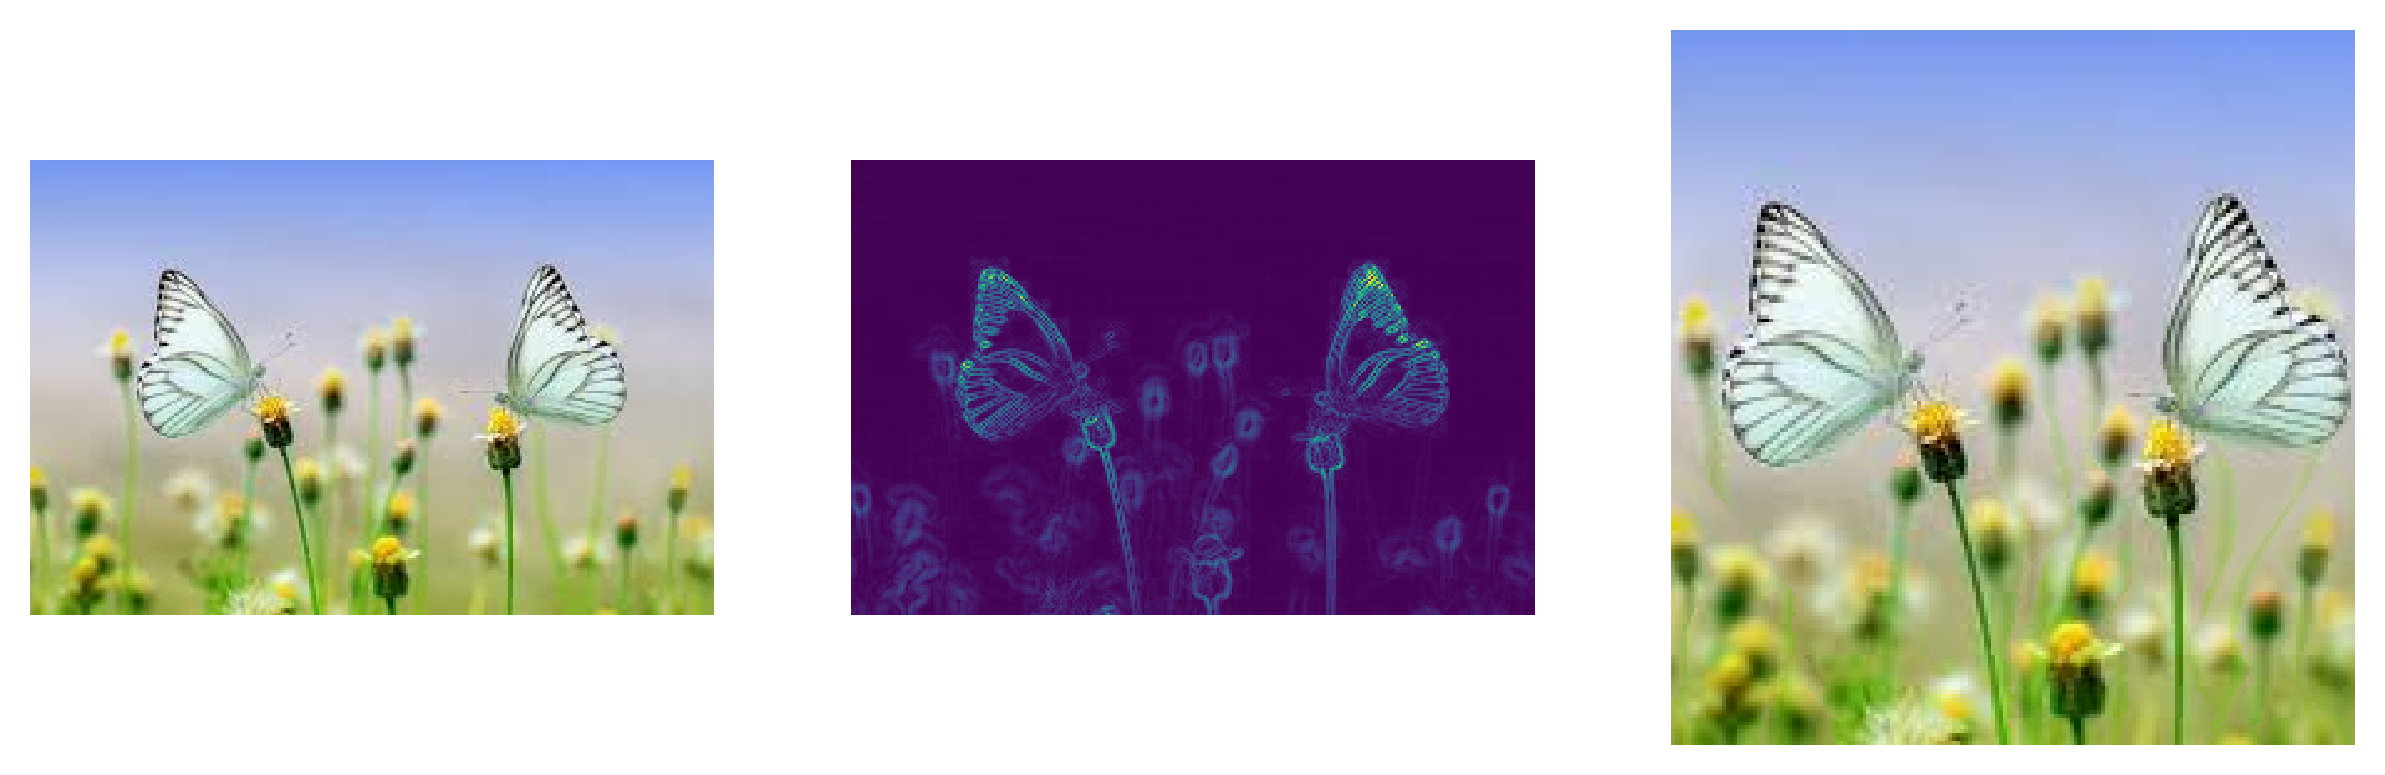

In [3]:
which_axis = "c"
num_seams = 100
in_filename = "img/two-butterfly.jpg"
img = imread(in_filename)
if which_axis == "r":
    out = crop_r(img, num_seams)
elif which_axis == "c":
    out = crop_c(img, num_seams)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(calc_energy(img))

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(out.astype(np.int16))

Show the optimum seam as red

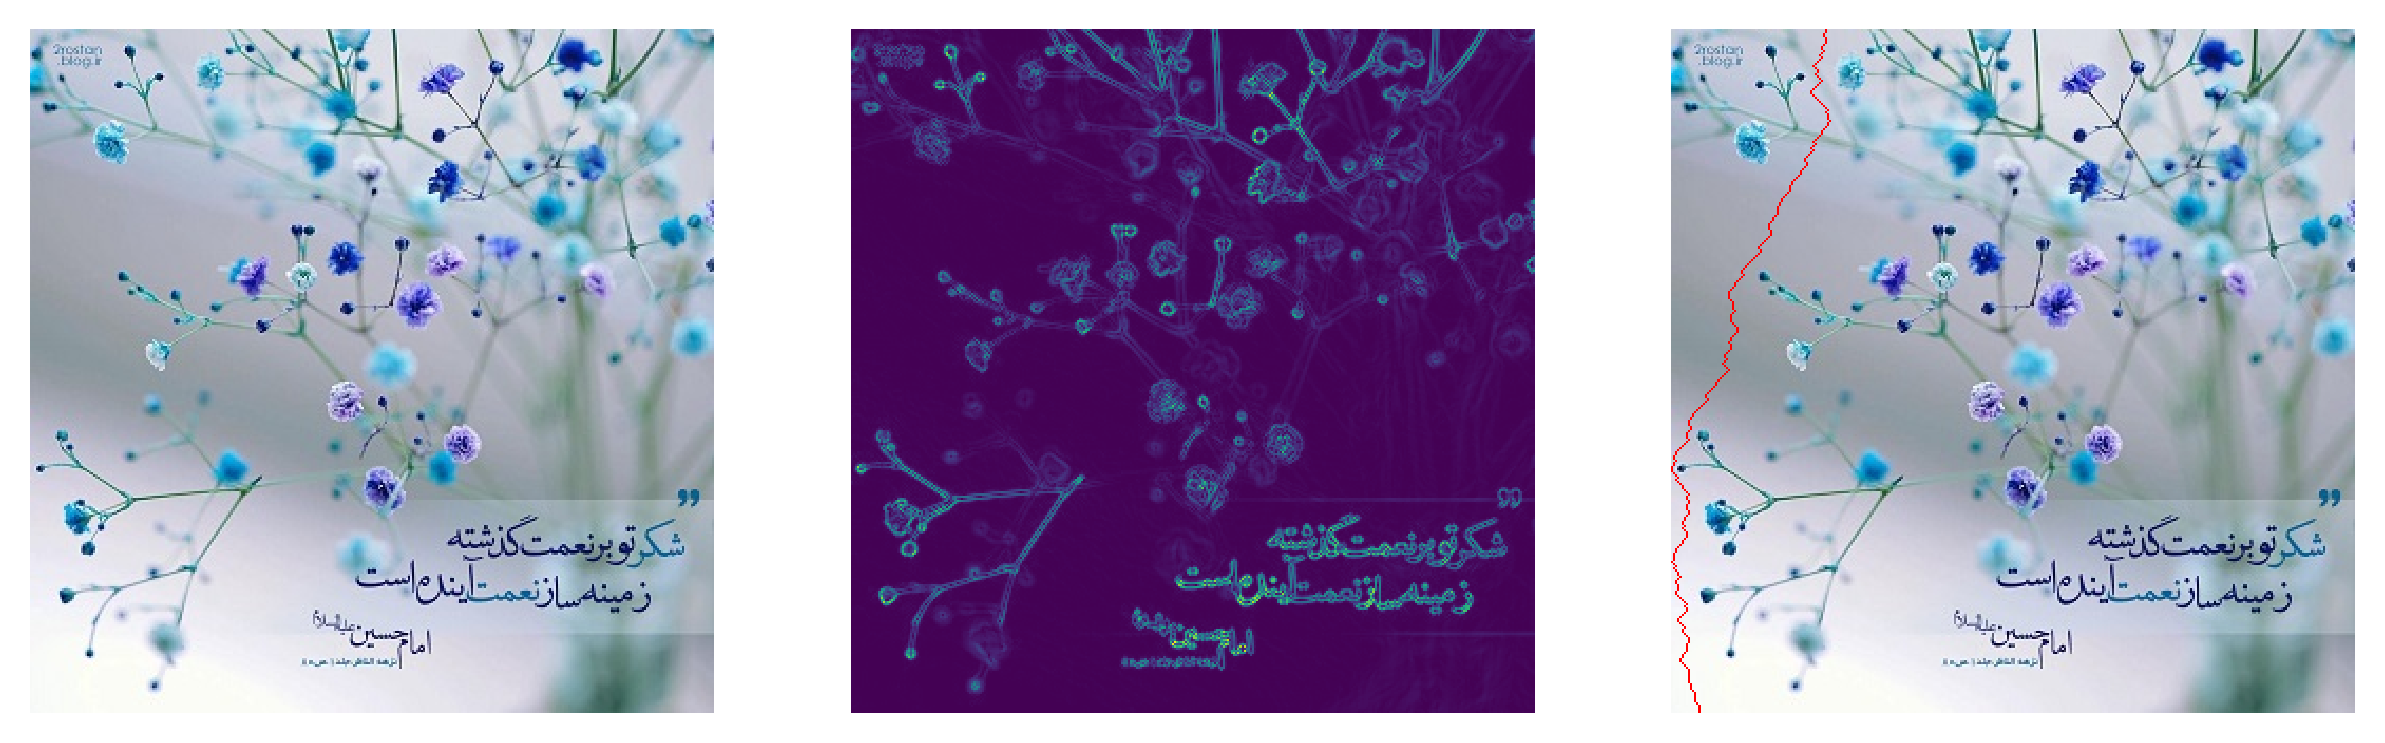

In [13]:
in_filename = "img/thanks.jpg"
img = imread(in_filename)
M, backtrack = minimum_seam(img)
seam_indices = find_optimal_seam(M, backtrack)
im = img.copy()
# Set the pixels corresponding to the seam indices to red
for i, j in seam_indices:
    im[i, j] = (255, 0, 0)  # Set RGB values to red

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(calc_energy(img))

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(im.astype(np.int16))

Make the image smaller in width and length: 324x324 -> 240x240

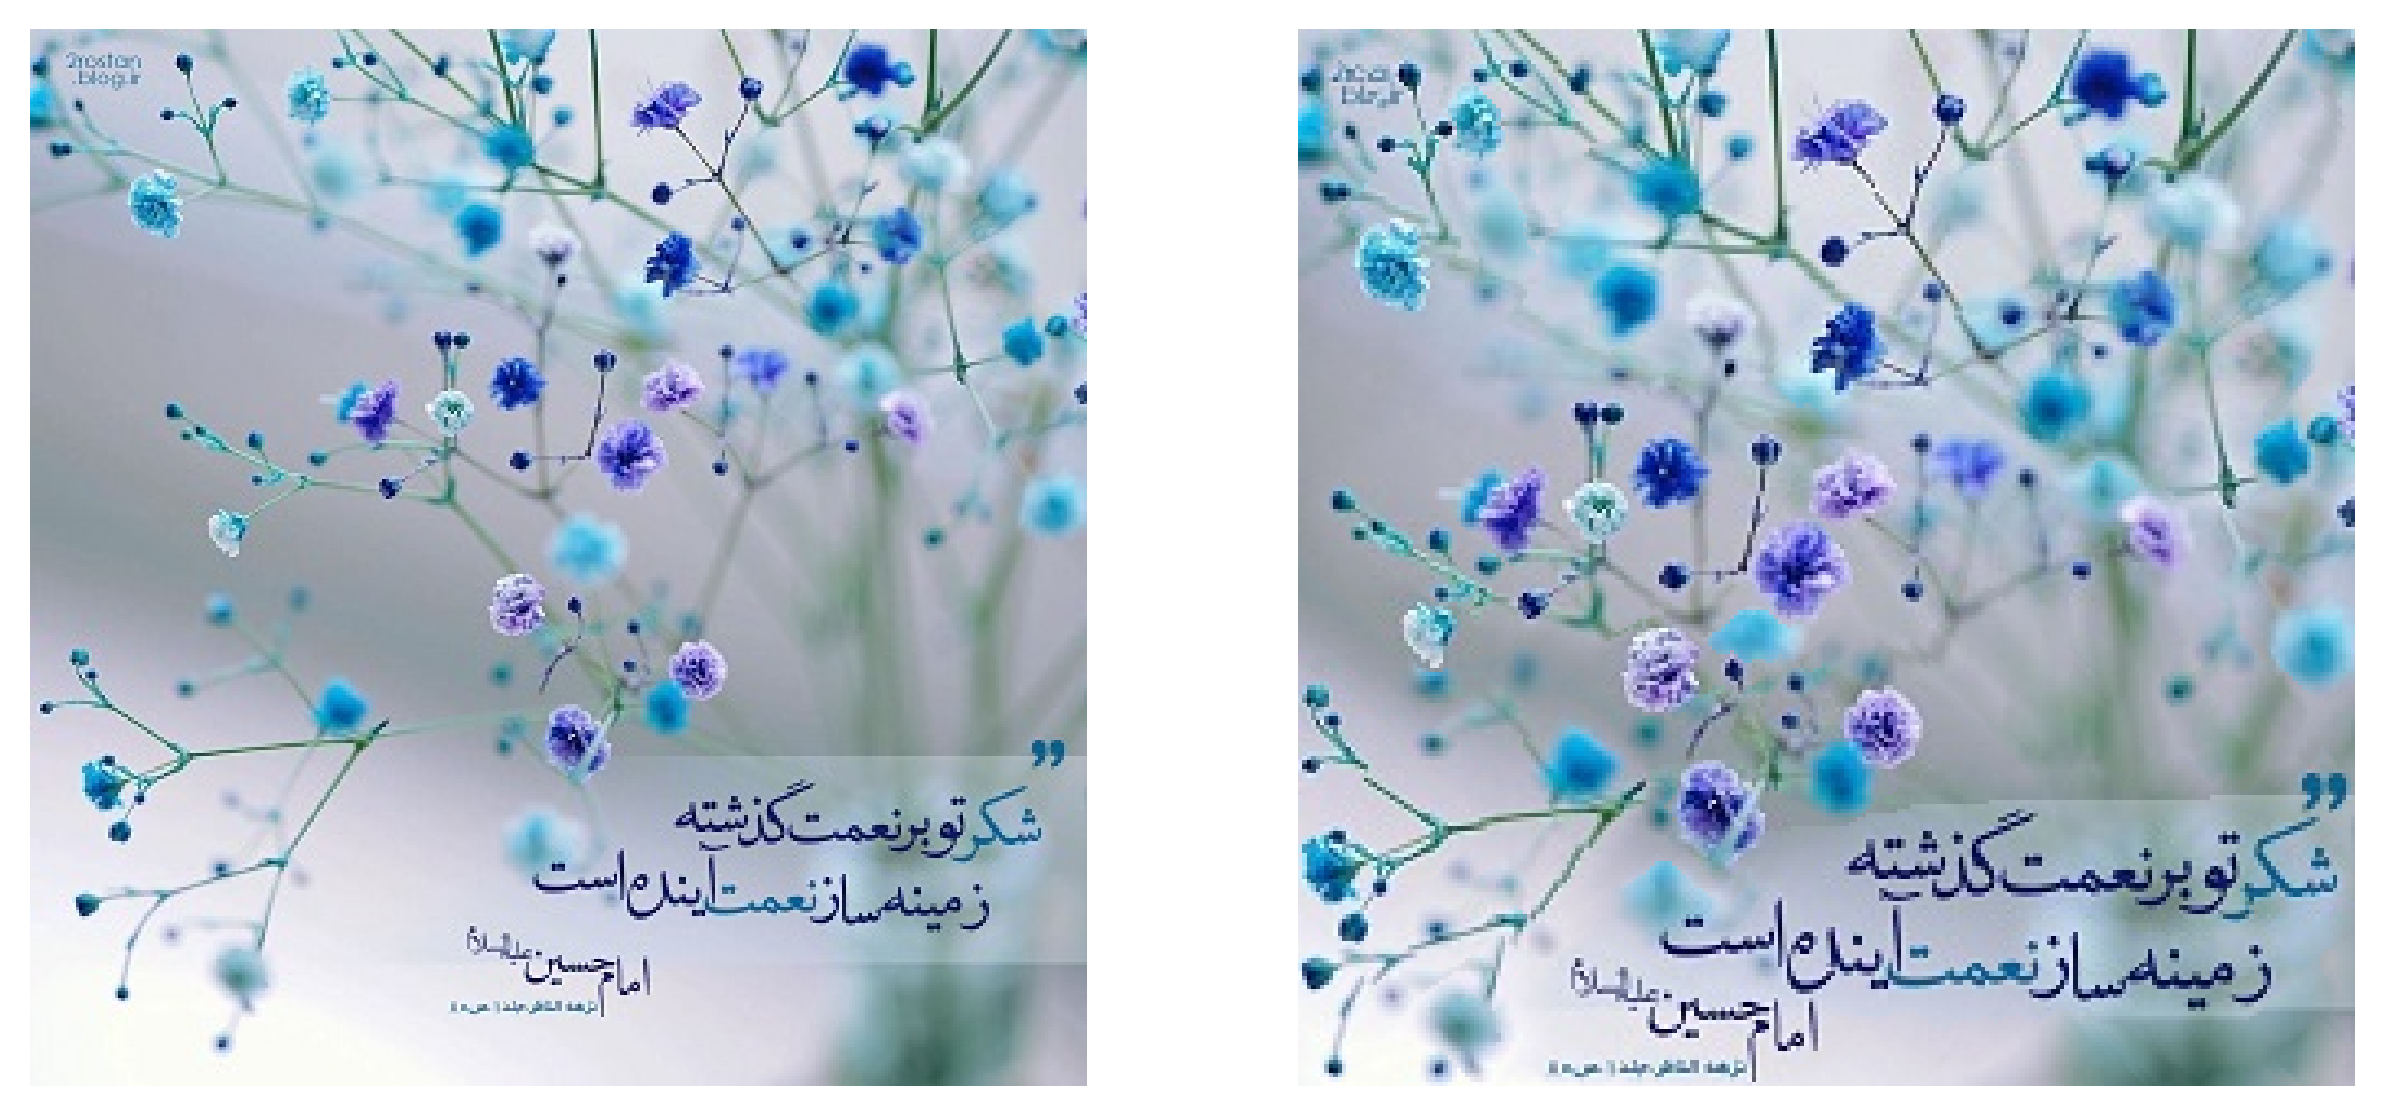

In [14]:
out = crop_c(img, 84)
out = crop_r(out, 84)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)

# plt.subplot(1, 3, 2)
# plt.axis("off")
# plt.imshow(calc_energy(img))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(out.astype(np.int16))

## Viterbi Algorithm

In [15]:
from hidden_markov import hmm

Defining the HMM model of page 37 of [Dr. Veisi's slides](https://www.dropbox.com/scl/fi/9ez77b75eyw1al55k086s/StatNLP-Lecture6-HMM.pdf?rlkey=2vd1mfqwsrbu3ru4il6hta4m7&dl=0)

In [16]:
# Define the Model
states = ("S0", "S1")
observations = ("A", "B")
start_prob_matrix = np.matrix([1, 0])
transition_matrix = np.matrix([[0.6, 0.4], [0, 1]])
emission_matrix = np.matrix([[0.8, 0.2], [0.3, 0.7]])

In [17]:
print(start_prob_matrix)
print(transition_matrix)
print(emission_matrix)

[[1 0]]
[[0.6 0.4]
 [0.  1. ]]
[[0.8 0.2]
 [0.3 0.7]]


In [18]:
hmm_model = hmm(
    states, observations, start_prob_matrix, transition_matrix, emission_matrix
)

In [ ]:
# The observations that we observe and feed to the model
obs1 = ("A", "A", "B")
hmm_model.forward_algo(obs1)

0.22080000000000002

In [ ]:
hmm_model.viterbi(obs1)

['S0', 'S0', 'S1']

Define another model with dictionaries

In [ ]:
# Define the Model
states = ("Rainy", "Sunny")
observations = ("walk", "shop", "clean")
start_probability = {"Rainy": 0.6, "Sunny": 0.4}
transition_probability = {
    "Rainy": {"Rainy": 0.7, "Sunny": 0.3},
    "Sunny": {"Rainy": 0.4, "Sunny": 0.6},
}
emission_probability = {
    "Rainy": {"walk": 0.1, "shop": 0.4, "clean": 0.5},
    "Sunny": {"walk": 0.6, "shop": 0.3, "clean": 0.1},
}

In [ ]:
# Converting dictionary to matrix
n = len(states)

start_prob_matrix = np.matrix(list(start_probability.values()))
print(start_prob_matrix)

transition_matrix = np.zeros((n, n))
for i, row_state in enumerate(states):
    for j, col_state in enumerate(states):
        transition_matrix[i, j] = transition_probability[row_state][col_state]
transition_matrix = np.matrix(transition_matrix)
print(transition_matrix)

rows = len(emission_probability)
cols = len(emission_probability["Rainy"])
emission_matrix = np.zeros((rows, cols))

for i, state in enumerate(emission_probability):
    for j, activity in enumerate(emission_probability[state]):
        emission_matrix[i][j] = emission_probability[state][activity]
emission_matrix = np.matrix(emission_matrix)
print(emission_matrix)

[[0.6 0.4]]
[[0.7 0.3]
 [0.4 0.6]]
[[0.1 0.4 0.5]
 [0.6 0.3 0.1]]


In [ ]:
hmm_model = hmm(
    states, observations, start_prob_matrix, transition_matrix, emission_matrix
)

In [ ]:
# The observations that we observe and feed to the model
obs1 = ("walk", "walk", "shop", "shop")
hmm_model.forward_algo(obs1)

0.013554839999999999

In [ ]:
hmm_model.viterbi(obs1)

['Sunny', 'Sunny', 'Rainy', 'Rainy']

---

**References:**

1. Shai Avidan and Ariel Shamir. "Seam Carving for Content-Aware Image Resizing." 
   - [Paper](https://perso.crans.org/frenoy/matlab2012/seamcarving.pdf) 
   - [Github, Python](https://github.com/vivianhylee/seam-carving)
   - [GitHub (C++)](https://github.com/loc-trinh/seamCarving)
2. [Implementing Seam Carving with Python, by Karthik Karanth](https://karthikkaranth.me/blog/implementing-seam-carving-with-python/)
3. [Intro to the Seam Carving Algorithm, by Ben Tanen](https://ben-tanen.com/projects/2020/10/08/seam-carving-pt1.html)

